# Manipulating capture data with `fvdb_reality_capture`

At its core, `fvdb_reality_capture` is a library of operators which operate on 3D captures which generally consist of:
 1. Posed images. _i.e._ Images with a world-to-camera transformation specifying from where each image was taken in the scene, and the parameters of the camera that captured them.
 2. Scanned 3D points which lie on surfaces captured from the scene.
 3. A mapping between images and points specifying which points were seen by which images.

This type of data may arise from capture hardware (_e.g._ a set of cameras and LiDAR sensors equipped with [Inertial Measurement Units (IMU)](https://en.wikipedia.org/wiki/Inertial_measurement_unit) sensors), or [from Structure-from-Motion (Sfm)](https://en.wikipedia.org/wiki/Structure_from_motion) capture which solves for camera poses and points using correspondences between a set of images.

`fvdb_reality_capture` aims to support loading in capture data stored in different formats into a common representation that can be easily manipulated by users.

To do this, data from a cature is stored in an `fvdb_reality_capture.SfmScene` object which acts as an in memory representation of a 3D capture.

Below, we'll look at some examples of how to load a capture from disk, and manipulate it using an `SfmScene`.

Let's first start by downloading some example capture data for this tutorial. 

In [1]:
# We'll use a few libraries in this tutorial for logging, plotting, image processing, and
# numerical computation
import fvdb_reality_capture as frc
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
import tqdm

# fvdb_reality_capture supports logging if enabled. We'll set the log level to logging.INFO which is somewhat
# verbose but is informative for seeing
# what's happening under the hood. If you want fewer logs, set level=logging.WARN. If you want
# more logs, set level=logging.DEBUG
logging.basicConfig(level=logging.INFO)

# Let's start by downloading some capture data. This will download a set of representative 3D capture
# datasets to a folder called "data/".
frc.download_example_data(dataset="all", download_path="./data")

INFO:fvdb_reality_capture.tools._download_example_data.download_example_data:Downloading dataset mipnerf360 from https://fvdb-data.s3.us-east-2.amazonaws.com/fvdb-reality-capture/360_v2.zip to data/360_v2/360_v2.zip
INFO:fvdb_reality_capture.tools._download_example_data.download_example_data:Dataset downloaded successfully.
INFO:fvdb_reality_capture.tools._download_example_data.download_example_data:Extracting archive 360_v2.zip to data/360_v2.
INFO:fvdb_reality_capture.tools._download_example_data.download_example_data:Downloading dataset gettysburg from https://fvdb-data.s3.us-east-2.amazonaws.com/fvdb-reality-capture/gettysburg.zip to data/gettysburg/gettysburg.zip
INFO:fvdb_reality_capture.tools._download_example_data.download_example_data:Dataset downloaded successfully.
INFO:fvdb_reality_capture.tools._download_example_data.download_example_data:Extracting archive gettysburg.zip to data/gettysburg.
INFO:fvdb_reality_capture.tools._download_example_data.download_example_data:Downl

## Loading and Plotting Capture Data

The downloaded data contains the MipNeRF360 dataset, a set of captures extracted by running [COLMAP](https://github.com/colmap/colmap), a widely used SfM algorithm on a collection of images.

The data is located at `data/360_v2`, and consists of seven captures, each in its own directory (_e.g._ `data/360_v2/bicycle`, `data/360_v2/garden`, etc.).
The layout of this directory is not important for this tutorial since loading it is handled by `fvdb_reality_capture`, but if you're curious you can [read about the COLMAP data format here](https://colmap.github.io/format.html).

Let's now load one of the datasets to an `SfmScene` object and analyze it.

In [2]:
sfm_scene: frc.SfmScene = frc.SfmScene.from_colmap("data/360_v2/garden")

INFO:load colmap:Computing and caching visible points per image...
100%|██████████| 138766/138766 [00:00<00:00, 259549.62it/s]


Here we used the `fvdb_reality_capture.io` module to load data in COLMAP format to an `SfmScene`. 

In brief, an `SfmScene` is an immutable representation of a capture (modifying it will produce a copy). Its most important attributes are:
 1. `SfmScene.cameras`: A dictionary mapping unique camera IDs to `SfmCameraMetadata` objects which camera parameters (e.g. projection matrices, distortion parameters). The size of this dictionary matches the number of cameras used to capture the scene (so if you scanned a scene with a pair of stereo cameras, then `len(SfmScene.cameras)` will be 2).
 2. `SfmScene.images`: A list of `SfmImageMetadata` objects which contain paths to the images and optional masks, a reference to the camera (`SfmCameraMetadata`) used to capture each image, their camera-to-world (and inverse) transformations, and the set of 3D points visible in each image.
 3. `points/points_rgb/points_err`: Numpy arrays of shape `(N,3)`/`(N,3)`/`(N,)` encoding known surface points in the scene, their RGB colors, and an unnormalized confidence value of the accuracy of that point. Note, `N` denotes the number of points here.

Now that we have a loaded `SfmScene`, let's plot some of its images, and the projected 3D points within those images.

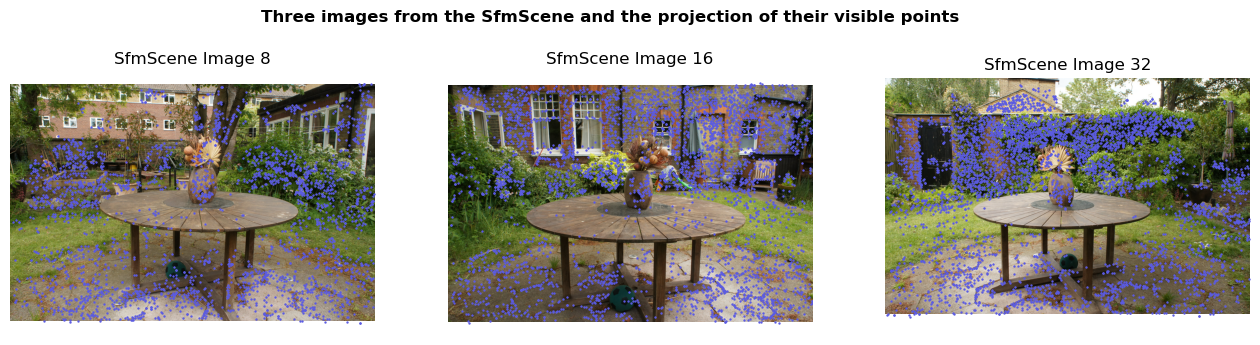

In [ ]:
# Visualize an image in an SfmScene and the 3D points visible from that images
# projected onto the image plane as blue dots.
def plot_image_from_scene(scene: frc.SfmScene, image_id: int, point_color: str):
    # Here we get metadata about the image_id^th image in the dataset
    image_meta: frc.SfmImageMetadata = scene.images[image_id]

    # Here we get metatada about the camera that capured the image
    camera_meta: frc.SfmCameraMetadata = image_meta.camera_metadata

    # Get the visible 3d points for this image
    # scene.points returns the set of all points in the scene, and
    # image_meta.point_indices returns the indices of the points visible in the image
    assert image_meta.point_indices is not None, f"No points are visible in image {image_id}"
    visible_points_3d: np.ndarray = scene.points[image_meta.point_indices]

    # Project those points onto the image plane
    # 1. Get the world -> camera space transform and projection matrix
    #  - The world-to-camera matrix is a property of the image since it varies over images.
    #  - The projection matrix is a property of the camera since it varies
    #    per-camera but is the same for all images captured with that camera
    # The world_to_camera_matrix is a (4, 4)-shaped numpy array encoding an SE(3) transform as a 4x4
    # matrix.
    # The projection matrix is a (3, 3)-shaped numpy array encoding a perspective projection
    # from 3D to 2D.
    world_to_cam_matrix: np.ndarray = image_meta.world_to_camera_matrix
    projection_matrix: np.ndarray = camera_meta.projection_matrix

    # 2. Transform world points to camera space using the world-to-camera matrix.
    # The camera coordinate space is one where the camera center lies at the origin (0, 0, 0),
    # the +Z axis is looking down the center of the image, the +X axis points along the right of
    # the image, and the +Y axis points upward in the image.
    visible_points_3d_cam_space = world_to_cam_matrix[:3,:3] @ visible_points_3d.T + world_to_cam_matrix[:3,3:4]

    # 3. Transform camera space coordinates to image space (pixel) coordinates using the
    #    projection matrix.
    # The projection matrix transforms camera coordinates to image space and has the form
    # [[fx, 0,  cx],
    #  [0,  fy, cy],
    #  [0,  0,  1]]
    # where (fx, fy) are the x and y focal lengths (in pixel units), and (cx, cy) is the optical
    # center (in pixel units).
    visible_points_2d = projection_matrix @ visible_points_3d_cam_space
    visible_points_2d /= visible_points_2d[2]

    # Load the image and convert to RGB (OpenCV uses BGR by default)
    loaded_image = cv2.imread(image_meta.image_path)
    assert loaded_image is not None, f"Failed to load image at {image_meta.image_path}"
    loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)

    # If there's a mask associated with this image, use it to zero out
    # masked pixels
    if image_meta.mask_path:
        mask = cv2.imread(image_meta.mask_path, cv2.IMREAD_GRAYSCALE)
        assert mask is not None, f"Failed to load mask at {image_meta.mask_path}"
        loaded_image *= (mask[..., np.newaxis] > 127)

    # Plot the image and projected points as blue dots
    plt.title(f"SfmScene Image {image_id}")
    plt.axis("off")
    plt.imshow(loaded_image)
    plt.scatter(visible_points_2d[0], visible_points_2d[1], color=point_color, marker=".", s=2)


def plot_three_images(scene: frc.SfmScene, title: str, title_color=None, point_color="#5b5be2ff"):
    # Plot three images and points alongside each other
    plt.figure(figsize=(16, 4))
    plt.suptitle(title, color=title_color, fontweight='bold')
    plt.subplot(1, 3, 1)
    plot_image_from_scene(scene, 8, point_color=point_color)
    plt.subplot(1, 3, 2)
    plot_image_from_scene(scene, 16, point_color=point_color)
    plt.subplot(1, 3, 3)
    plot_image_from_scene(scene, 32, point_color=point_color)
    plt.show()

plot_three_images(sfm_scene, "Three images from the SfmScene and the projection of their visible points")

## Manipulating an `SfmScene`


### Basic `SfmScene` manipulation

We can do basic manipulations on an `SfmScene` such as filtering out certain images or points.
More advanced manipulations can be done using the `fvdb_reality_capture.transforms` module described below.

Let's start with a (somewhat contrived) example where we filter out points in the scene whose X
coordinate is less than the X coordinate of the mean of all points. 

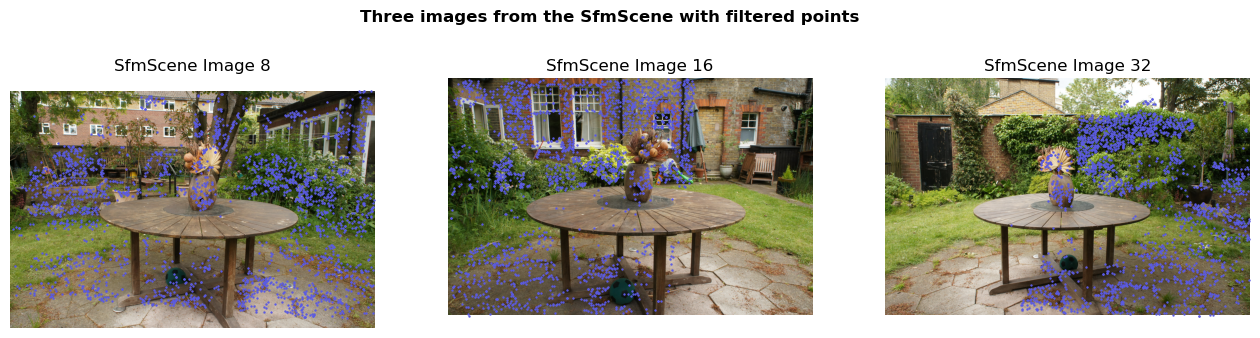

Original scene has {sfm_scene.points.shape[0]} points and filtered scene has {filtered_pts_scene.points.shape[0]} points


In [4]:
# Mean of all points
points_mean = np.mean(sfm_scene.points, axis=0)

# Mask for points with X >= mean X. True values mean keep the point.
mask = sfm_scene.points[:, 0] >= points_mean[0]

# Create a new SfmSCene with points removed.
# The set of visible points is automatically updated
filtered_pts_scene = sfm_scene.filter_points(mask)

# Plot three images and points in the new scene alongside each other
plot_three_images(filtered_pts_scene, "Three images from the SfmScene with filtered points")

print("Original scene has {sfm_scene.points.shape[0]} points and filtered scene has {filtered_pts_scene.points.shape[0]} points")

Now let's filter out every other image in the dataset using a simple mask. This operation can be useful
to remove certain images based on a given criteria (e.g. having too few visible points).

Note how the new plot has different images and the number of images in the filtered scene is halved.

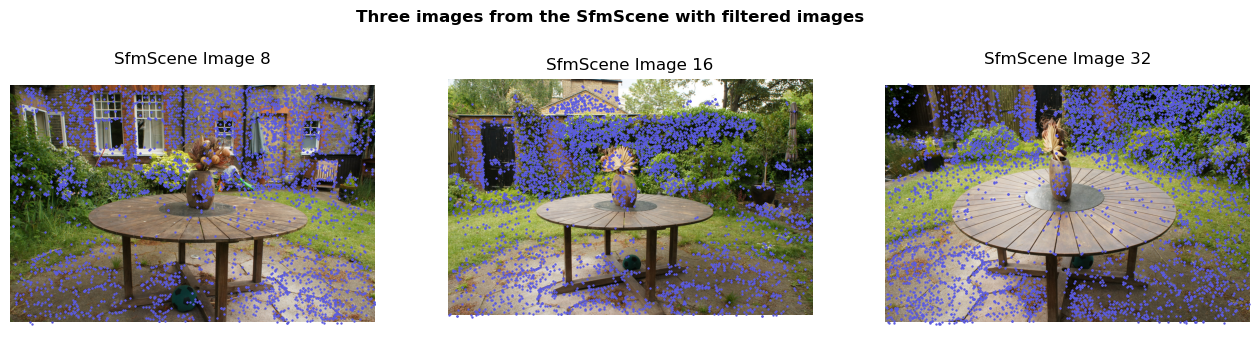

Original scene has 185 images, and filtered scene has 93 images


In [5]:
image_mask = np.zeros(sfm_scene.num_images, dtype=np.bool)
image_mask[::2] = True # Keep every other image starting from 0

every_other_img_scene = sfm_scene.filter_images(image_mask)

plot_three_images(every_other_img_scene, "Three images from the SfmScene with filtered images")

print(f"Original scene has {sfm_scene.num_images} images, and filtered scene has {every_other_img_scene.num_images} images")

### Advanced Manipulation Operations using `fvdb_reality_capture.transforms`

`fvdb_reality_capture` comes equipped with a number of more advanced transformations that can be applied to an `SfmScene`. 
These include operations to downsample images, normalize the scene, crop the scene, and filter outlier points. 
You can also define your own custom transformations. 

Let's look at some examples of transformations.

#### Downsampling Images in an `SfmScene`
You can downsample images in an `SfmScene` using the `fvdb_reality_capture.transforms.DownsampleImages` which will resize the images and cache them.

INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 8, sampling mode 3, and quality 100.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:No downsampled images found in the cache.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Generating images downsampled by a factor of 8 and saving to cache.
Rescaling DSC08140.JPG from 5187 x 3361 to 648 x 420: 100%|██████████| 185/185 [00:25<00:00,  7.40imgs/s]
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaled 185 images by a factor of 8 and saved to cache with sampling mode 3 and quality 100.


Original size of image 0 is (3361, 5187), downsampled size is (420, 648)


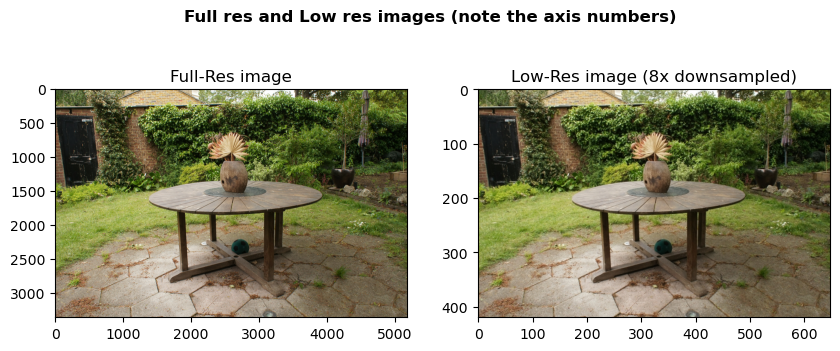

In [6]:
# This transform downsamples images in the scene by a factor of 8
rescale_transform = frc.transforms.DownsampleImages(8)

# Downsample images in the scene. This will cache the downsampled images for later use,
# and update the paths accordingly.
rescaled_scene = rescale_transform(sfm_scene)

print(f"Original size of image 0 is {sfm_scene.images[0].image_size}, downsampled size is {rescaled_scene.images[0].image_size}")

img0_full_res = cv2.imread(sfm_scene.images[0].image_path)
assert img0_full_res is not None, "Failed to load full resolution image"
img0_full_res = cv2.cvtColor(img0_full_res, cv2.COLOR_BGR2RGB)
img0_low_res = cv2.imread(rescaled_scene.images[0].image_path)
assert img0_low_res is not None, "Failed to load low resolution image"
img0_low_res = cv2.cvtColor(img0_low_res, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 4))
plt.suptitle("Full res and Low res images (note the axis numbers)", fontweight="bold")
plt.subplot(1, 2, 1)
plt.title("Full-Res image")
plt.imshow(img0_full_res)
plt.subplot(1, 2, 2)
plt.title("Low-Res image (8x downsampled)")
plt.imshow(img0_low_res)
plt.show()

Whew, that took a while 😂! The first time you run this transformation, the Transform will cache all the downsampled images for re-use later. After that, applying the same transformation again will re-use the cached images and will be instantaneous. Let's see an example:

INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 8, sampling mode 3, and quality 100.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.


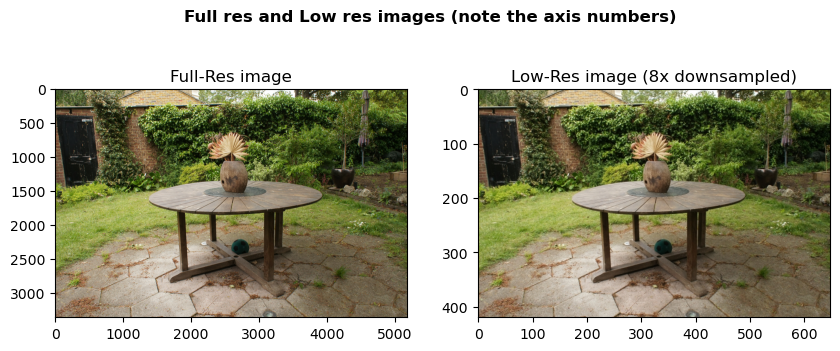

In [7]:
# Downsample images in the scene. This will cache the downsampled images for later use,
# and update the paths accordingly.
rescaled_scene = rescale_transform(sfm_scene)

img0_full_res = cv2.imread(sfm_scene.images[0].image_path)
assert img0_full_res is not None, "Failed to load full resolution image"
img0_full_res = cv2.cvtColor(img0_full_res, cv2.COLOR_BGR2RGB)
img0_low_res = cv2.imread(rescaled_scene.images[0].image_path)
assert img0_low_res is not None, "Failed to load low resolution image"
img0_low_res = cv2.cvtColor(img0_low_res, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 4))
plt.suptitle("Full res and Low res images (note the axis numbers)", fontweight="bold")
plt.subplot(1, 2, 1)
plt.title("Full-Res image")
plt.imshow(img0_full_res)
plt.subplot(1, 2, 2)
plt.title("Low-Res image (8x downsampled)")
plt.imshow(img0_low_res)
plt.show()

#### Normalizing an `SfmScene`
Let's look another example showing how to normalize a scene with `fvdb_reality_capture.transforms.NormalizeScene`. This normalizes a scene using various heuristics. In this case, we'll center the scene about its median then align it with PCA.

In [8]:
# Normalize a scene by centering it about the median of its points
# and aligning it along the top three principal axes of the camera centers.
# Other types of normalization exist as well such as ecef2enu for geospatial
# normalization
normalization_transform = frc.transforms.NormalizeScene(normalization_type="pca")
normalized_scene = normalization_transform(sfm_scene)

print(f"Before normalization, scene center is at {np.median(sfm_scene.points, axis=0)}, with scale {sfm_scene.image_centers.max(0) - sfm_scene.points.min(0)}")
print(f"After normalization, scene center is at {np.median(normalized_scene.points, axis=0)} with scale {normalized_scene.image_centers.max(0) - normalized_scene.points.min(0)}")

# NOTE: The median after transformation will NOT be 0 since the transformation is not a pure translation.
# instead, the fixed point of the normalization is the median of the original points.
# i.e. The following is true:
def print_fixed_point():
    median = np.median(sfm_scene.points, axis=0)
    tx = normalized_scene.transformation_matrix
    print("Fixed point check: T * median = ", (tx[:3, :3] @ median + tx[:3, 3]))
print_fixed_point()

INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca


Before normalization, scene center is at [0.1907731 2.1362865 1.4691257], with scale [43.7783128  41.03833703 25.50118337]
After normalization, scene center is at [-0.03681892  0.06804667  0.36076348] with scale [63.3367801  52.39398801 12.59278424]
Fixed point check: T * median =  [0. 0. 0.]


#### Cropping an `SfmScene`
We'll see one more transform example to crop a scene to a given bounding box. This transform will remove points outside the bounding box, and mask out pixels in images which correspond to rays that do not intersect that bounding box.

INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Cropping scene to bounding box: [ 0.1907731  2.1362865 -0.5        5.         5.         5.       ]
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:No masks found in the cache for cropping.
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:No transform found in cache, regenerating.
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Computing image masks for cropping and saving to cache.
Computing image masks for cropping: 100%|██████████| 185/185 [00:06<00:00, 29.45imgs/s]


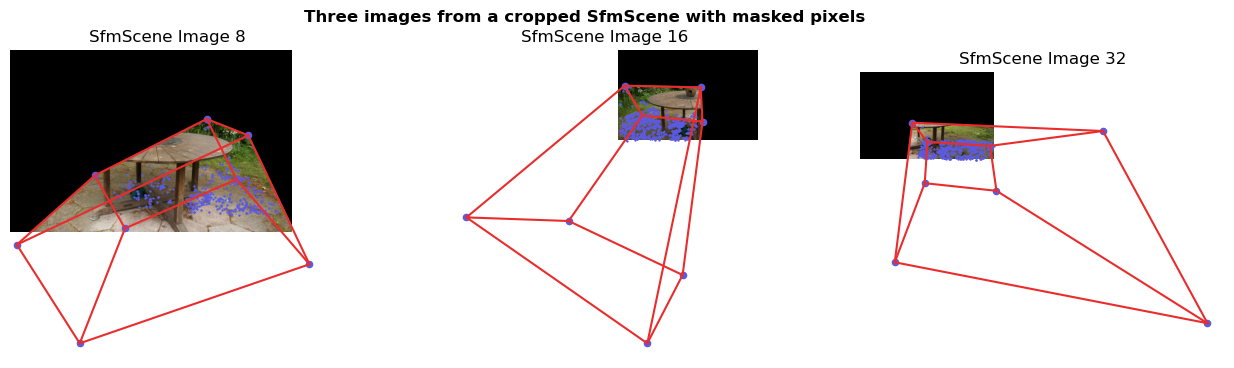

In [9]:
def plot_projected_bbox(scene: frc.SfmScene, image_id: int, point_color: str, line_color):
    min_x, min_y, min_z, max_x, max_y, max_z = scene.scene_bbox

    # Here we get metadata about the image_id^th image in the dataset
    image_meta: frc.SfmImageMetadata = scene.images[image_id]

    # Here we get metatada about the camera that capured the image
    camera_meta: frc.SfmCameraMetadata = image_meta.camera_metadata

    world_to_cam_matrix: np.ndarray = image_meta.world_to_camera_matrix
    projection_matrix: np.ndarray = camera_meta.projection_matrix

    # If the scene bbox is infinite, we can't plot it
    if np.any(np.isinf(scene.scene_bbox)):
        return

    # (8, 4)-shaped array representing the corners of the bounding cube containing the input points
    # in homogeneous coordinates
    cube_bounds_world_space_homogeneous = np.array(
        [
            [min_x, min_y, min_z, 1.0],
            [min_x, min_y, max_z, 1.0],
            [min_x, max_y, min_z, 1.0],
            [min_x, max_y, max_z, 1.0],
            [max_x, min_y, min_z, 1.0],
            [max_x, min_y, max_z, 1.0],
            [max_x, max_y, min_z, 1.0],
            [max_x, max_y, max_z, 1.0],
        ]
    )

    # Transform the cube corners to camera space
    cube_bounds_cam_space = (
        world_to_cam_matrix @ cube_bounds_world_space_homogeneous.T
    )  # [4, 8]
    # Divide out the homogeneous coordinate -> [3, 8]
    cube_bounds_cam_space = cube_bounds_cam_space[:3, :] / cube_bounds_cam_space[-1, :]
    cube_bounds_cam_space[-1] = np.maximum(cube_bounds_cam_space[-1], 0.1)

    # Project the camera-space cube corners into image space [3, 3] * [8, 3] - > [8, 2]
    cube_verts_2d = projection_matrix @ cube_bounds_cam_space  # [3, 8]
    # Divide out the homogeneous coordinate and transpose -> [8, 2]
    cube_verts_2d = (cube_verts_2d[:2, :] / cube_verts_2d[2, :]).T

    # Compute a list of line segments for each cube edge as a pair of start and end points
    segments = [
        [cube_verts_2d[0], cube_verts_2d[1]], # [-1, -1, -1] -> [-1, -1, +1]
        [cube_verts_2d[1], cube_verts_2d[3]], # [-1, -1, +1] -> [-1, +1, +1]
        [cube_verts_2d[3], cube_verts_2d[2]], # [-1, +1, +1] -> [-1, +1, -1]
        [cube_verts_2d[2], cube_verts_2d[0]], # [-1, +1, -1] -> [-1, -1, -1]
        [cube_verts_2d[0], cube_verts_2d[4]], # [-1, -1, -1] -> [+1, -1, -1]
        [cube_verts_2d[1], cube_verts_2d[5]], # [-1, -1, +1] -> [+1, -1, +1]
        [cube_verts_2d[2], cube_verts_2d[6]], # [-1, +1, -1] -> [-1, +1, -1]
        [cube_verts_2d[3], cube_verts_2d[7]], # [-1, +1, +1] -> [+1, +1, +1]
        [cube_verts_2d[4], cube_verts_2d[5]], # [+1, -1, -1] -> [+1, -1, +1]
        [cube_verts_2d[5], cube_verts_2d[7]], # [+1, -1, +1] -> [+1, +1, +1]
        [cube_verts_2d[7], cube_verts_2d[6]], # [+1, +1, +1] -> [+1, +1, -1]
        [cube_verts_2d[6], cube_verts_2d[4]], # [+1, +1, -1] -> [+1, -1, -1]
    ]

    # Get the segments in a format compatible with matplotlib
    # i.e. [start_x, end_x], [start_y, end_y]
    segment_x = [[seg[0][0], seg[1][0]] for seg in segments]
    segment_y = [[seg[0][1], seg[1][1]] for seg in segments]

    # Plot the cube edges
    for i in range(len(segment_x)):
        plt.plot(segment_x[i], segment_y[i], color=line_color)

    # Plot the cube vertices
    plt.scatter(cube_verts_2d[:,0], cube_verts_2d[:,1], color=point_color, marker="o", s=20)


def plot_three_images_with_bbox(
        scene: frc.SfmScene,
        title: str,
        title_color=None,
        point_color="#5b5be2ff",
        line_color: str = "#e92d2d"):
    # Plot three images and points alongside each other
    plt.figure(figsize=(16, 4))
    plt.suptitle(title, color=title_color, fontweight='bold')
    plt.subplot(1, 3, 1)
    plot_image_from_scene(scene, 8, point_color=point_color)
    plot_projected_bbox(scene, 8, point_color=point_color, line_color=line_color)
    plt.subplot(1, 3, 2)
    plot_image_from_scene(scene, 16, point_color=point_color)
    plot_projected_bbox(scene, 16, point_color=point_color, line_color=line_color)
    plt.subplot(1, 3, 3)
    plot_image_from_scene(scene, 32, point_color=point_color)
    plot_projected_bbox(scene, 32, point_color=point_color, line_color=line_color)
    plt.show()

# Crop the scene along the XY axis starting from the median X and Y point position
median_point = np.median(rescaled_scene.points, axis=0)
crop_transform = frc.transforms.CropScene(bbox=[median_point[0], median_point[1], -0.5, 5, 5, 5])

# We're transforming the images from the scene with downsampled images here since writing out
# large masks is slow
cropped_scene = crop_transform(rescaled_scene)

plot_three_images_with_bbox(cropped_scene, "Three images from a cropped SfmScene with masked pixels")

Note that the masks may look a bit larger than the set of visible points here. This is because they are the computed by taking the convex-hull of the projection of the bounding cube of the cropped points in image space. This leads to pixels being included in some views that don't have any points, which is desirable for Gaussian splatting to capture the background regions outside a bounding box.

#### Composing Transforms
Very often you want to build a data processing pipeline that composes multiple different transforms together. You can do this easily with `fvdb_reality_capture.transforms.Compose`. Let's see an example that combines the above three transformations.

INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 8, sampling mode 3, and quality 100.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Cropping scene to bounding box: [0. 0. 0. 2. 2. 2.]
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:No masks found in the cache for cropping.
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:No transform found in cache, regenerating.
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Computing image masks for cropping and saving to cache.
Computing image masks for cropping: 100%|██████████| 185/185 [00:06<00:00, 28.73imgs/s]


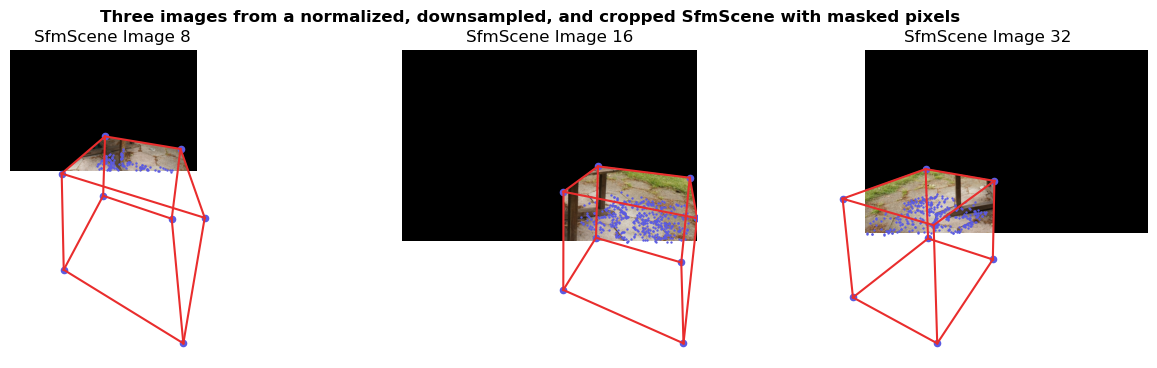

In [10]:
transform = frc.transforms.Compose(
    frc.transforms.NormalizeScene(normalization_type="pca"),
    frc.transforms.DownsampleImages(8),
    frc.transforms.CropScene(bbox=[0, 0, 0, 2, 2, 2]),
)

tx_scene = transform(sfm_scene)

plot_three_images_with_bbox(tx_scene, "Three images from a normalized, downsampled, and cropped SfmScene with masked pixels")

**⚠️ Warning about transform oder ⚠️**
One caveat about composing transforms is that *order matters*. For example, when you crop a scene, the image masks are pre-computed as part of the transformation. If you normalize the scene after cropping, your images and bounding boxes won't match as expected. 

Here we show an example where we crop the scene, which caches image masks, and then normalize the scene. Note how the plotted bounding boxes don't align with the image mask.

INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 8, sampling mode 3, and quality 100.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Cropping scene to bounding box: [0. 0. 0. 2. 2. 2.]
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Cached transform does not match input scene transform. Clearing the cache and regenerating transform.
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Computing image masks for cropping and saving to cache.
Computing image masks for cropping: 100%|██████████| 185/185 [00:01<00:00, 110.34imgs/s]
INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca


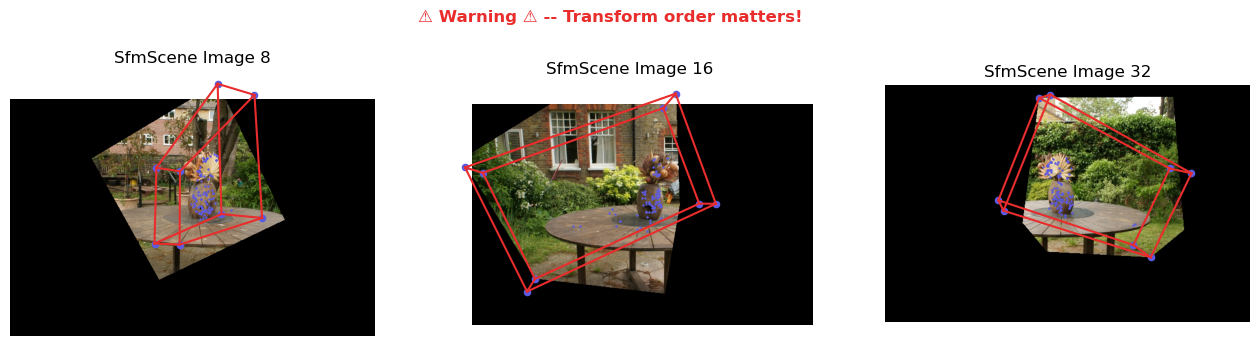

In [11]:
transform = frc.transforms.Compose(
    frc.transforms.DownsampleImages(8),
    frc.transforms.CropScene(bbox=[0, 0, 0, 2, 2, 2]),
    frc.transforms.NormalizeScene(normalization_type="pca"),
)

tx_scene = transform(sfm_scene)

plot_three_images_with_bbox(tx_scene, "⚠️ Warning ⚠️ -- Transform order matters!", title_color="#e92d2d")

### Defining your own transforms
**⚠️ Warning ⚠️** The internal transform API is still being designed and may change in the future.

While `fvdb_reality_capture` provides a set of useful transforms, you may need to write your own for a special use case.

Here's we'll implement a simple (but somewhat contrived) transform that both converts RGB images to BGR, and masks out a box in the middle of each image. It will cache the results and return a new `SfmScene` with the proper masks.

Every transform in `fvdb_reality_capture` must inherit from `fvdb_reality_capture.transforms.BaseTransform` and be decorated with the `@fvdb_reality_capture.transforms.transform` decorator.
It must also implement the following methods:
 - `name()`: A `staticmentod` which returns a unique name for this type of transform
 - `state_dict()`: A method which returns a serlializable (with `torch.save`) seriazed representation of the transform.
 - `from_state_dict(self, state_dict: dict[str, Any])`: A `staticmethod` which constructs this transform from a state dict
 - `__call__(self, input_scene: SfmScene)` which applies this transform to an input `SfmScene`

Let's see how to implement these for our `CropAndConvertToBGR` transform below

In [ ]:
from typing import Any

@frc.transforms.transform
class MaskMiddleAndConvertToBGR(frc.transforms.BaseTransform):
    def __init__(self, box_fraction: float):
        super().__init__()
        self._logger = logging.getLogger(f"{self.__class__.__module__}.{self.__class__.__name__}")
        if not (0.0 <= box_fraction <= 1.0):
            raise ValueError("box_fraction must be between 0 and 1 exclusively")
        self._box_fraction = box_fraction

    @staticmethod
    def name() -> str:
        return "MaskMiddleAndConvertToBGR"

    def state_dict(self) -> dict[str, Any]:
        return {"box_fraction": self._box_fraction}

    @staticmethod
    def from_state_dict(state_dict: dict[str, Any]) -> "MaskMiddleAndConvertToBGR":
        if "box_fraction" not in state_dict:
            raise ValueError("state_dict must contain 'box_fraction' key")
        return MaskMiddleAndConvertToBGR(state_dict["box_fraction"])

    def __call__(self, input_scene: frc.SfmScene) -> frc.SfmScene:
        cache: frc.SfmCache = input_scene.cache

        self._logger.info(f"Applying {self.name()} with box_fraction={self._box_fraction} to SfmScene with {input_scene.num_images} images")

        # We're going to create a unique folder in the cache for the images and masks computed
        # by an instance of this transform.
        # Cache folder names can only contain alphanumeric characters and underscores so we replace
        # the '.' in the box_fraction floating point number with an '_'
        cache_folder_name = f"maskrgb2bgr_bf{str(self._box_fraction).replace('.', '_')}"

        regenerate_cache = False

        # A cache represents a folder on the filesystem that can contain files
        # (e.g. images, masks, etc). Here we either create a new folder in the current cache folder
        # or get a reference to one if it already exists in the cache.
        output_cache = cache.make_folder(cache_folder_name)

        # We generate one image and one mask in the cache for each input image
        # If the number of files in the cache folder is incorrect, we need to regenerate
        if output_cache.num_files != input_scene.num_images * 2:
            self._logger.info(f"Cache folder {output_cache.current_folder_path} has {output_cache.num_files} files, expected {input_scene.num_images * 2}. Regenerating cache.")
            output_cache.clear_current_folder()
            regenerate_cache = True

        # Recompute the images and masks if the cache was missing or incomplete
        if regenerate_cache:
            for i, image_meta in enumerate(tqdm.tqdm(input_scene.images)):
                # Load the image
                img = cv2.imread(image_meta.image_path)
                assert img is not None, f"Failed to load image at {image_meta.image_path}"

                h, w = img.shape[:2]
                crop_h = int(h * self._box_fraction)
                crop_w = int(w * self._box_fraction)
                start_y = (h - crop_h) // 2
                start_x = (w - crop_w) // 2

                # Create a mask that is black in the cropped region and white elsewhere
                mask = np.ones((h, w), dtype=np.uint8) * 255
                mask[start_y:start_y+crop_h, start_x:start_x+crop_w] = 0

                # Save the cropped image and mask to the cache folder
                image_filename = f"image_{i:04d}"
                mask_filename = f"mask_{i:04d}"

                # Also convert the image to BGR
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                # Write the image and mask to the cache
                output_cache.write_file(name=image_filename, data=img, data_type="png")
                output_cache.write_file(name=mask_filename, data=mask, data_type="png")


        # Create new image metadata with updated paths to the cropped images and masks
        new_image_metadata = []
        for i, image_meta in enumerate(input_scene.images):
            image_filename = f"image_{i:04d}.png"
            mask_filename = f"mask_{i:04d}.png"
            new_image_path = output_cache.current_folder_path / image_filename
            new_mask_path = output_cache.current_folder_path / mask_filename
            new_image_meta = frc.SfmImageMetadata(
                world_to_camera_matrix=image_meta.world_to_camera_matrix,
                camera_to_world_matrix=image_meta.camera_to_world_matrix,
                camera_metadata=image_meta.camera_metadata,
                camera_id=image_meta.camera_id,
                image_id=image_meta.image_id,
                image_path=str(new_image_path),
                mask_path=str(new_mask_path),
                point_indices=image_meta.point_indices
            )
            new_image_metadata.append(new_image_meta)

        # Replace the old image metadata with the new one
        return frc.SfmScene(
            cameras=input_scene.cameras,
            images=new_image_metadata,
            points=input_scene.points,
            points_rgb=input_scene.points_rgb,
            points_err=input_scene.points_err,
            transformation_matrix=input_scene.transformation_matrix,
            scene_bbox=input_scene.scene_bbox,
            cache=output_cache,
        )

We can use this new transform like any other transform as above. Let's apply it to the loaded scene to see its effect. Here the transform masks a small box in the middle of each image and converts the colors to BGR.

INFO:__main__.MaskMiddleAndConvertToBGR:Applying MaskMiddleAndConvertToBGR with box_fraction=0.25 to SfmScene with 185 images
INFO:__main__.MaskMiddleAndConvertToBGR:Cache folder data/360_v2/garden/_cache/cache_1/maskrgb2bgr_bf0_25 has 0 files, expected 370. Regenerating cache.
100%|██████████| 185/185 [01:39<00:00,  1.87it/s]


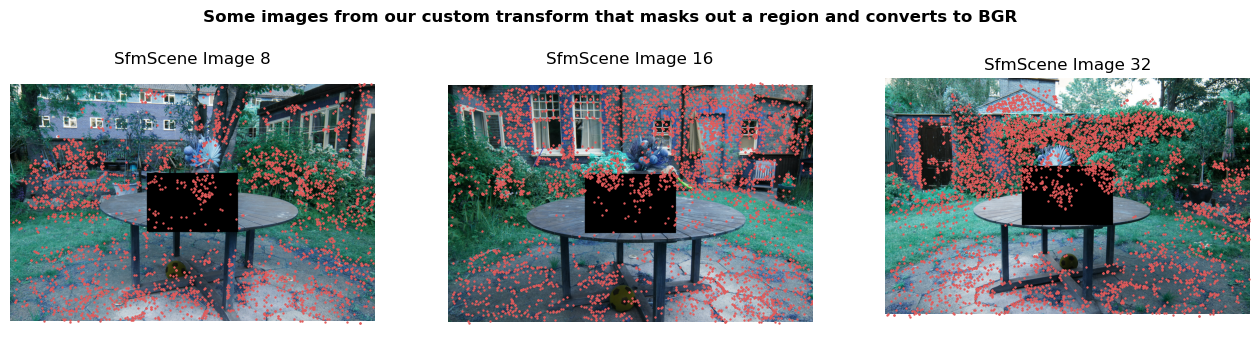

In [13]:
custom_transform = MaskMiddleAndConvertToBGR(box_fraction=0.25)
tx_scene = custom_transform(sfm_scene)

plot_three_images_with_bbox(
    tx_scene,
    "Some images from our custom transform that masks out a region and converts to BGR",
    point_color="#e25b5bff")

We can also compose this transform with any other as before. Let's see an example where we normalize the scene, downscale the images, apply our center mask and BGR conversion, and then crop the scene. Note how the plotted images now include the mask from our transform as well as the mask from the scene cropping.

INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 8, sampling mode 3, and quality 100.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:__main__.MaskMiddleAndConvertToBGR:Applying MaskMiddleAndConvertToBGR with box_fraction=0.75 to SfmScene with 185 images
INFO:__main__.MaskMiddleAndConvertToBGR:Cache folder data/360_v2/garden/_cache/cache_1/downsampled_8x_jpg_q100_m3/maskrgb2bgr_bf0_75 has 0 files, expected 370. Regenerating cache.
100%|██████████| 185/185 [00:11<00:00, 16.74it/s]
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Cropping scene to bounding box: [0. 0. 0. 2. 2. 2.]
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:No masks found in the cache for cropping.
INFO:fvdb_reality_capture.transforms.crop_sc

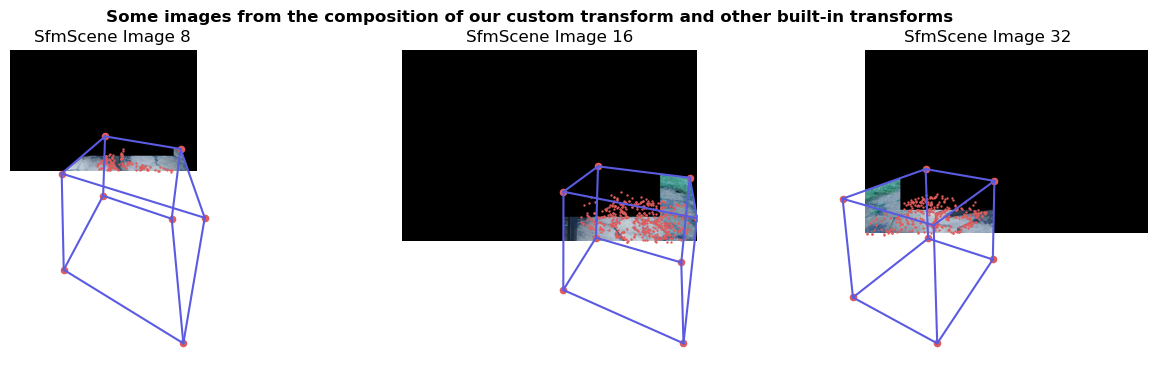

In [14]:
transform = frc.transforms.Compose(
    frc.transforms.NormalizeScene(normalization_type="pca"),
    frc.transforms.DownsampleImages(8),
    MaskMiddleAndConvertToBGR(box_fraction=0.75),
    frc.transforms.CropScene(bbox=[0, 0, 0, 2, 2, 2]),
)

tx_scene = transform(sfm_scene)

plot_three_images_with_bbox(
    tx_scene,
    "Some images from the composition of our custom transform and other built-in transforms",
    point_color="#e25b5bff",
    line_color="#5b5be2ff")

#### A note about caching 
This note is a bit advanced but important to know if you're writing your own transforms.

A transform modifies an input scene in a way that can possibly be expensive to compute. To deal with this, transforms use a chaching mechanism that let's the transform store the outputs of expensive computations for re-use later without requiring the user to manage a lot of files on the file system. The `fvdb_reality_capture.io.SfmCache` class represents a directory on the filesystem where intermediate data gets stored. You can create (or get a refence to) a subdirectory of the current cache directory using the `Cache.make_folder(name: str)` method. This method returns a new `Cache` object for that subdirectory.

Transforms make extensive use of subdirectories to cache results from a sequence of transforms with a particular set of parameters.

Let's see how this plays out in our example for the transform:
```python
transform = frc.transforms.Compose(
    frc.transforms.NormalizeScene(normalization_type="pca"),
    frc.transforms.DownsampleImages(8),
    MaskMiddleAndConvertToBGR(box_fraction=0.75),
    frc.transforms.CropScene(bbox=[0, 0, 0, 2, 2, 2]),
)
```

This transform does four things encoded as four `BaseTransform` objects:
 1. Normalizes the scene by centering at the median of its points and rotating it to align with the top three principal axes of those points. 
 2. Downsamples every image in the scene by a factor of 8.
 3. Masks out a box in the middle of each image that is 75% of the image size, and converts images to BGR.
 4. Crops points which lie in the box from (0.0, 0.0, 0.0) to (2.0, 2.0, 2.0) and masks out pixels that don't see this box.


Here is how this sequence of transforms leverages the cache. Let's say the sfm_scene starts with a cache directory called `cache/`
 - Normalizing does not cache anythng and just transforms the scene. 
   - The cache directory is `cache/`
 - Downsampling images caches the downsampled images. 
   - The cache directory is `cache/downsampled_8x_jpg_q100_m3/`.
 - Our custom transform caches masks and converted images. 
   - The cache directory is `cache/downsampled_8x_jpg_q100_m3/maskrgb2bgr_bf0_75/`.
 - The crop transform caches masks for the bounding cube as well as a file containing the transformation matrix of the scene. If the transformation matrix for the current scene doesn't match the cached one, the cached images are regenerated. 
   - The cache directory is `cache/downsampled_8x_jpg_q100_m3/maskrgb2bgr_bf0_75/Crop_0_0_0_0_0_0_2_0_2_0_2_0_png_True/`.


Let's say you changed the box fraction in our custom transform from 0.75 to 0.25 after you ran the transform above. This new transform corresponds to the following transform:
```python
transform = frc.transforms.Compose(
    frc.transforms.NormalizeScene(normalization_type="pca"),
    frc.transforms.DownsampleImages(8),
    MaskMiddleAndConvertToBGR(box_fraction=0.25),
    frc.transforms.CropScene(bbox=[0, 0, 0, 2, 2, 2]),
)
```

The result would be as follows:
 - Normalizing the scene happens as usual applying the PCA transform.
   - The cache directory is `cache/`
 - Downsampling images re-uses the existing cached images.
   - The cache directory is `cache/downsampled_8x_jpg_q100_m3/`.
 - Our transform creates a new directory called `maskrgb2bgr_bf0_25`. This directory is empty, so the masks and images need to be regenerated.
   - `cache/downsampled_8x_jpg_q100_m3/maskrgb2bgr_bf0_25/`
 - The `CropScene` transform creates a new directory called `Crop_0_0_0_0_0_0_2_0_2_0_2_0_png_True` inside the `cache/downsampled_8x_jpg_q100_m3/maskrgb2bgr_bf0_25/`. This directory is empty, so the masks for the crop are regenerated.

Note how this pattern let us change some parameters and re-use the existing downsampled images. This mechanism allows us to quickly explore different parameters for transformation while maximally re-using cached information.

Let's see this all in action by running some code:



In [15]:
logging.info("Applying transform_1 to sfm_scene again to see cache reuse")
logging.info("-------------------------------")
# Our original transform. Look at the logs to see that the cache is reused
transform_1 = frc.transforms.Compose(
    frc.transforms.NormalizeScene(normalization_type="pca"),
    frc.transforms.DownsampleImages(8),
    MaskMiddleAndConvertToBGR(box_fraction=0.75),
    frc.transforms.CropScene(bbox=[0, 0, 0, 2, 2, 2]),
)
scene_1 = transform_1(sfm_scene)
logging.info("\n")

logging.info("Applying a new transform_2 with a different downsampling factor to see new cache generation")
logging.info("-------------------------------")
# A new transform with a different downsampling factor. Look at the logs to see that a new cache
# is generated for the downsampled images
transform_2 = frc.transforms.Compose(
    frc.transforms.NormalizeScene(normalization_type="pca"),
    frc.transforms.DownsampleImages(8),
    MaskMiddleAndConvertToBGR(box_fraction=0.25),
    frc.transforms.CropScene(bbox=[0, 0, 0, 2, 2, 2]),
)
scene_2 = transform_2(sfm_scene)

INFO:root:Applying transform_1 to sfm_scene again to see cache reuse
INFO:root:-------------------------------
INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 8, sampling mode 3, and quality 100.
INFO:fvdb_reality_capture.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:__main__.MaskMiddleAndConvertToBGR:Applying MaskMiddleAndConvertToBGR with box_fraction=0.75 to SfmScene with 185 images
INFO:fvdb_reality_capture.transforms.crop_scene.CropScene:Cropping scene to bounding box: [0. 0. 0. 2. 2. 2.]
INFO:root:

INFO:root:Applying a new transform_2 with a different downsampling factor to see new cache generation
INFO:root:-------------------------------
INFO:fvdb_reality_capture.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization